<a href="https://colab.research.google.com/github/taravatp/Multi_Spectral_Image_Segmentation/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install import_ipynb

In [ ]:
!pip install ml_collections

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/Vision_Impulse_Task

/content/drive/MyDrive/Vision_Impulse_Task


In [ ]:
import torch
import torch.nn as nn
import import_ipynb

import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
import pickle

In [ ]:
import networks.vit_seg_configs as configs
from networks.transunet import Trans_Unet
from MSI_dataset import MSI_data
from networks.Unet import unet
from networks.Efficient_Network import ENet

importing Jupyter notebook from transunet.ipynb
importing Jupyter notebook from MSI_dataset.ipynb
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 76.6 MB/s eta 0:00:00
importing Jupyter notebook from Unet.ipynb
importing Jupyter notebook from Efficient_Network.ipynb


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# Instantiating the Dataloaders/Model/Optimizer/HyperParameters


In [ ]:
BATCHSIZE = 16
EPOCHS = 10

In [ ]:
train_data = MSI_data(flag='train', multispectral=False)
validation_data = MSI_data(flag='validation', multispectral=False)
test_data = MSI_data(flag='test', multispectral=False)

train_dataloader = torch.utils.data.DataLoader(train_data,batch_size=BATCHSIZE,shuffle=True)
validation_dataloader = torch.utils.data.DataLoader(validation_data,batch_size=BATCHSIZE,shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data,batch_size=BATCHSIZE,shuffle=True)

In [ ]:
print('number of training samples:',len(train_dataloader)*BATCHSIZE)
print('number of validation samples',len(validation_dataloader)*BATCHSIZE)
print('number of test samples',len(test_dataloader)*BATCHSIZE)

number of training samples: 4560
number of validation samples 576
number of test samples 576


In [ ]:
CONFIGS = {
    'ViT-B_16': configs.get_b16_config(),
    'ViT-B_32': configs.get_b32_config(),
    'ViT-L_16': configs.get_l16_config(),
    'ViT-L_32': configs.get_l32_config(),
    'ViT-H_14': configs.get_h14_config(),
    'R50-ViT-B_16': configs.get_r50_b16_config(),
    'R50-ViT-L_16': configs.get_r50_l16_config(),
    'testing': configs.get_testing(),
}

config = CONFIGS['ViT-B_16']
model = Trans_Unet(config,in_channels=3).to(device)

# model = unet().to(device)

# model = ENet(num_classes=3, in_channels=12).to(device)

In [ ]:
params = [p for p in model.parameters() if p.requires_grad]
LEARNING_RATE = 0.0001
optimizer = torch.optim.Adam(params, lr=LEARNING_RATE)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=20,gamma=0.1)

In [ ]:
criterion = nn.CrossEntropyLoss()

# Evaluation functions



In [ ]:
from sklearn.metrics import cohen_kappa_score, accuracy_score, f1_score

In [ ]:
def evaluate(ground_truth,predicted_labels):

  num_classes = 3
  class_labels = list(range(num_classes))

  # Flatten the tensors for calculation
  ground_truth = ground_truth.view(-1).cpu()

  predicted_labels = torch.softmax(predicted_labels, dim=1)
  _ , predicted_labels = torch.max(predicted_labels, dim=1)
  predicted_labels = predicted_labels.view(-1).cpu()

  overall_accuracy = accuracy_score(ground_truth, predicted_labels)
  f1 = f1_score(ground_truth, predicted_labels, labels=class_labels, average='weighted')
  kappa = cohen_kappa_score(ground_truth, predicted_labels, labels=class_labels)

  confusion_matrix = np.zeros((num_classes, num_classes), dtype=np.uint64)
  for t, p in zip(ground_truth, predicted_labels):
      confusion_matrix[int(t), int(p)] += 1
  intersection = np.diag(confusion_matrix)
  union = (confusion_matrix.sum(1) + confusion_matrix.sum(0) - intersection)
  iou = intersection / union.astype(np.float32)
  miou = np.mean(iou)

  return overall_accuracy, f1, kappa, miou

# Training

In [ ]:
def train_and_validation():

  train_metrics = {
      'segmentation_loss': [],
      'accuracy': [],
      'f1': [],
      'kappa': [],
      'miou': []
    }

  validation_metrics = {
      'segmentation_loss': [],
      'accuracy': [],
      'f1': [],
      'kappa': [],
      'miou': []
    }


  for epoch in range(EPOCHS):

    total_accuracy = 0
    total_f1 = 0
    total_kappa = 0
    total_miou = 0
    total_segmentation_loss = 0

    time_start = time.time()

    model.train()
    for iter,batch in enumerate(train_dataloader):

      input_image,target_image = batch[0].to(device), batch[1].to(device) # [16, 3, 256, 256] and [16, 3, 256, 256]
      target_image = torch.squeeze(target_image).long()
      prediction = model(input_image)
      loss = criterion(prediction,target_image)
      total_segmentation_loss += loss.item()

      accuracy, f1, kappa, miou = evaluate(target_image,prediction)
      total_accuracy += accuracy
      total_f1 += f1
      total_kappa += kappa
      total_miou += miou

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()


    # lr_scheduler.step()
    print("########################################")
    print(f"Epoch {epoch+1}/{EPOCHS} - training time elapsed: {time.time() - time_start}")
    train_metrics['segmentation_loss'].append(total_segmentation_loss/(iter+1))
    train_metrics['accuracy'].append(total_accuracy/(iter+1))
    train_metrics['f1'].append(total_f1/(iter+1))
    train_metrics['kappa'].append(total_kappa/(iter+1))
    train_metrics['miou'].append(total_miou/(iter+1))

    print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {train_metrics['segmentation_loss'][-1]}")
    print(f"Epoch {epoch+1}/{EPOCHS} - Train Acuracy: {train_metrics['accuracy'][-1]}")
    print(f"Epoch {epoch+1}/{EPOCHS} - Train F1: {train_metrics['f1'][-1]}")
    print(f"Epoch {epoch+1}/{EPOCHS} - Train kappa: {train_metrics['kappa'][-1]}")
    print(f"Epoch {epoch+1}/{EPOCHS} - Train MIOU: {train_metrics['miou'][-1]}")


    time_start = time.time()
    total_accuracy = 0
    total_f1 = 0
    total_kappa = 0
    total_miou = 0
    total_segmentation_loss = 0
    print("####################")

    model.eval()
    for iter,batch in enumerate(validation_dataloader):
      input_image,target_image = batch[0].to(device), batch[1].to(device)
      target_image = torch.squeeze(target_image).long()
      prediction = model(input_image)

      loss = criterion(prediction,target_image)
      total_segmentation_loss += loss.item()

      accuracy, f1, kappa, miou = evaluate(target_image,prediction)
      total_accuracy += accuracy
      total_f1 += f1
      total_kappa += kappa
      total_miou += miou


    print(f"Epoch {epoch+1}/{EPOCHS} - validation time elapsed: {time.time() - time_start}")

    validation_metrics['segmentation_loss'].append(total_segmentation_loss/(iter+1))
    validation_metrics['accuracy'].append(total_accuracy/(iter+1))
    validation_metrics['f1'].append(total_f1/(iter+1))
    validation_metrics['kappa'].append(total_kappa/(iter+1))
    validation_metrics['miou'].append(total_miou/(iter+1))

    print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {validation_metrics['segmentation_loss'][-1]}")
    print(f"Epoch {epoch+1}/{EPOCHS} - Train Acuracy: {validation_metrics['accuracy'][-1]}")
    print(f"Epoch {epoch+1}/{EPOCHS} - Train F1: {validation_metrics['f1'][-1]}")
    print(f"Epoch {epoch+1}/{EPOCHS} - Train kappa: {validation_metrics['kappa'][-1]}")
    print(f"Epoch {epoch+1}/{EPOCHS} - Train MIOU: {validation_metrics['miou'][-1]}")


  torch.save(model.state_dict(), f"RGB-TRANSUNET.pth")
  return train_metrics, validation_metrics

In [ ]:
train_metrics, validation_metrics = train_and_validation()

########################################
Epoch 1/10 - training time elapsed: 7890.883311033249
Epoch 1/10 - Train Loss: 0.6362640186360008
Epoch 1/10 - Train Acuracy: 0.77175651684142
Epoch 1/10 - Train F1: 0.7780978375467452
Epoch 1/10 - Train kappa: 0.6074965677141323
Epoch 1/10 - Train MIOU: 0.5743160144958469
####################
Epoch 1/10 - validation time elapsed: 949.7755932807922
Epoch 1/10 - Train Loss: 0.48796675105889636
Epoch 1/10 - Train Acuracy: 0.82933920401114
Epoch 1/10 - Train F1: 0.832067517635645
Epoch 1/10 - Train kappa: 0.6893551745494034
Epoch 1/10 - Train MIOU: 0.6307263366177831
########################################
Epoch 2/10 - training time elapsed: 256.541944026947
Epoch 2/10 - Train Loss: 0.48473716817404094
Epoch 2/10 - Train Acuracy: 0.8243626109340735
Epoch 2/10 - Train F1: 0.8275695006718178
Epoch 2/10 - Train kappa: 0.6907992115735081
Epoch 2/10 - Train MIOU: 0.6428976755820159
####################
Epoch 2/10 - validation time elapsed: 33.306906223

In [ ]:
train_loss_history = train_metrics['segmentation_loss']
validation_loss_history = validation_metrics['segmentation_loss']

train_accuracy_history = train_metrics['accuracy']
validation_accuracy_history = validation_metrics['accuracy']

train_f1_history = train_metrics['f1']
validation_f1_history = validation_metrics['f1']

train_kappa_history = train_metrics['kappa']
validation_kappa_history = validation_metrics['kappa']

train_miou_history = train_metrics['miou']
validation_miou_history = validation_metrics['miou']

Text(0, 0.5, 'Loss')

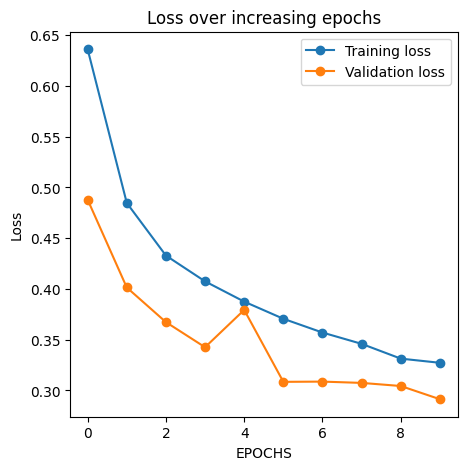

In [ ]:
#plotting the results
plt.figure(figsize=(5,5))
plt.plot(train_loss_history, "o-", label = 'Training loss')
plt.plot(validation_loss_history, "o-", label = 'Validation loss')
plt.legend()
plt.title("Loss over increasing epochs")
plt.xlabel("EPOCHS")
plt.ylabel("Loss")

In [ ]:
import matplotlib.gridspec as gridspec

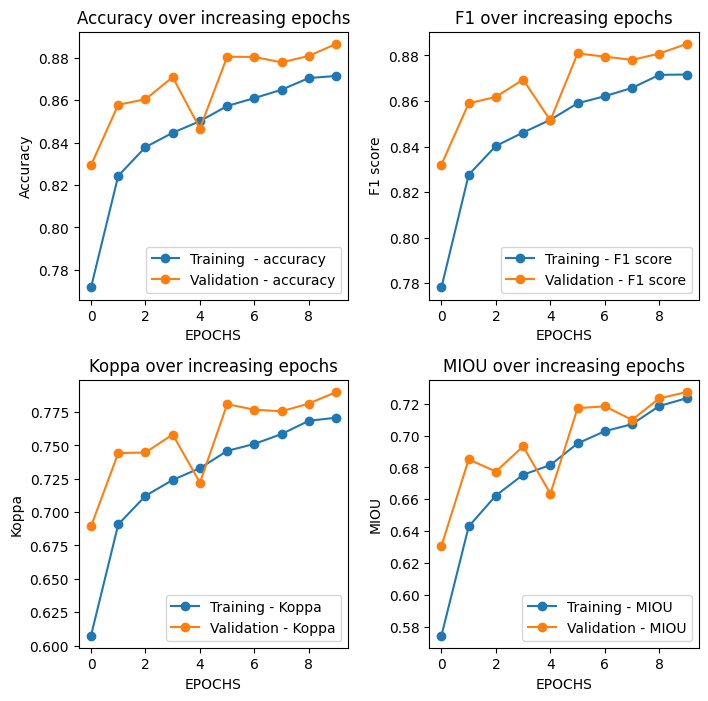

In [ ]:
gs = gridspec.GridSpec(2, 2)
fig = plt.figure(figsize=(8, 8))

plt.subplot(gs[0, 0])
plt.plot(train_accuracy_history, "o-", label='Training  - accuracy')
plt.plot(validation_accuracy_history, "o-", label='Validation - accuracy')
plt.legend()
plt.title("Accuracy over increasing epochs")
plt.xlabel("EPOCHS")
plt.ylabel("Accuracy")

plt.subplot(gs[0, 1])
plt.plot(train_f1_history, "o-", label='Training - F1 score')
plt.plot(validation_f1_history, "o-", label='Validation - F1 score')
plt.legend()
plt.title("F1 over increasing epochs")
plt.xlabel("EPOCHS")
plt.ylabel("F1 score")

plt.subplot(gs[1, 0])
plt.plot(train_kappa_history, "o-", label='Training - Koppa')
plt.plot(validation_kappa_history, "o-", label='Validation - Koppa')
plt.legend()
plt.title("Koppa over increasing epochs")
plt.xlabel("EPOCHS")
plt.ylabel("Koppa")

plt.subplot(gs[1, 1])
plt.plot(train_miou_history, "o-", label='Training - MIOU')
plt.plot(validation_miou_history, "o-", label='Validation - MIOU')
plt.legend()
plt.title("MIOU over increasing epochs")
plt.xlabel("EPOCHS")
plt.ylabel("MIOU")

gs.update(hspace=0.3, wspace=0.3)